In [1]:
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.signal
from scipy.signal import argrelextrema
from veneer import _rotare_img
%matplotlib inline

In [2]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)
    imArray /= 255
    # compute coefficients
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)
    coeffs_H[0] *= 0

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode)
    imArray_H *= 255
    imArray_H =  np.uint8(imArray_H)
    return imArray_H

In [3]:
def cross_image(im1, im2):
   # get rid of the color channels by performing a grayscale transform
   # the type cast into 'float' is to avoid overflows
   im1_gray = np.sum(im1.astype('float'), axis=2)
   im2_gray = np.sum(im2.astype('float'), axis=2)

   # get rid of the averages, otherwise the results are not good
   im1_gray -= np.mean(im1_gray)
   im2_gray -= np.mean(im2_gray)

   # calculate the correlation image; note the flipping of onw of the images
   return scipy.signal.fftconvolve(im1_gray, im2_gray[::-1,::-1], mode='same')

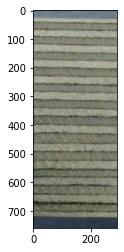

In [4]:
img = cv2.imread('pic/1.png')
plt.imshow(img)

(379, 146)


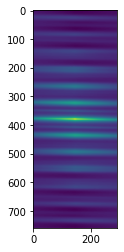

In [5]:
conv=cross_image(img,img)
maxi=np.unravel_index(np.argmax(conv), conv.shape)
print(maxi)
plt.imshow(conv)

In [6]:
mass=[]
for i in range(conv.shape[1]):
    filt=conv[:,i]
    locminarg = argrelextrema(filt, np.greater, order=5)[0]
    mass.append(np.round(len(locminarg)/2)+1)


(array([2.33, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.6 ]),
 array([11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ]),
 <BarContainer object of 10 artists>)

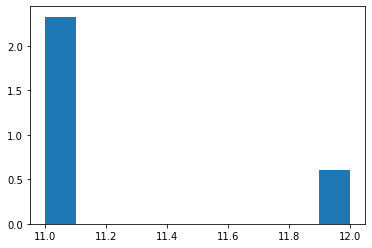

In [7]:
counts, bins = np.histogram(mass,bins=10)
plt.hist(bins[:-1], bins, weights=counts/100)

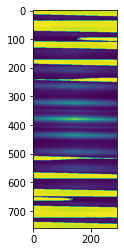

In [8]:
minLineLength =50
maxLineGap = 20
conv = conv / conv.max() # normalize the data to 0 - 1
conv = 255 * conv # Now scale by 255
conv_img = conv.astype(np.uint8)
plt.imshow(conv_img)
lines = cv2.HoughLinesP(conv_img,1,np.pi/180,100,minLineLength,maxLineGap)
for linee in lines:
    for x1, y1, x2, y2 in linee:
        cv2.line(conv_img, (x1, y1), (x2, y2), (0, 255, 0), 1)
cv2.imwrite('conv_imgn.jpg',conv_img)
round=20
clear_matrix=np.zeros(conv_img.shape)
# kernel = np.ones((1,20), np.uint8)  # note this is a horizontal kernel
# d_im = cv2.dilate(conv_img, kernel, iterations=1)
# clear_matrix = cv2.erode(d_im, kernel, iterations=1)
for i in range(clear_matrix.shape[1]):
    column = conv_img[:, i]
    for ind in range(0,len(column)-round,round):
        if np.sum(column[ind:ind+round])>1:
            column[ind]=1
            column[ind+1:ind+round]=0
    clear_matrix[:,i]=column
clear_matrix=np.where(clear_matrix>1, 1, clear_matrix)
veheer_count=np.sort(np.sum(clear_matrix,axis=0))-1

In [9]:
veheer_count

array([20., 25., 29., 30., 30., 31., 32., 32., 33., 33., 33., 33., 34.,
       34., 34., 34., 35., 35., 35., 35., 35., 35., 35., 35., 36., 36.,
       36., 37., 37., 37., 37., 37., 37., 38., 38., 38., 38., 38., 38.,
       39., 39., 39., 39., 39., 39., 39., 39., 39., 39., 39., 39., 39.,
       40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40.,
       41., 41., 41., 41., 41., 41., 41., 41., 41., 41., 42., 42., 42.,
       42., 42., 42., 42., 42., 42., 42., 42., 42., 42., 42., 42., 42.,
       42., 42., 42., 43., 43., 43., 43., 43., 43., 43., 43., 43., 43.,
       43., 43., 43., 43., 43., 43., 43., 43., 43., 43., 44., 44., 44.,
       44., 44., 44., 44., 44., 44., 45., 45., 45., 45., 45., 45., 45.,
       45., 45., 45., 45., 45., 45., 45., 46., 46., 46., 46., 46., 46.,
       46., 46., 46., 46., 46., 47., 47., 47., 47., 47., 47., 47., 47.,
       47., 47., 47., 47., 47., 47., 48., 48., 48., 48., 48., 48., 48.,
       48., 48., 48., 48., 48., 48., 48., 48., 48., 48., 48., 49

In [10]:

size =8
if not size%2:
    size +=1
kernel = np.ones((size,size),np.float32)/(size*size)
filtered= cv2.filter2D(img,-1,kernel)
filtered = img.astype('float32') - filtered.astype('float32')
filtered = filtered + 127*np.ones(img.shape, np.uint8)
filtered=np.uint8(filtered)
cv2.imwrite('outputhpass.jpg', filtered)

True

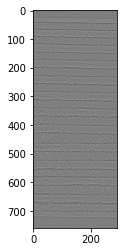

In [11]:
plt.imshow(filtered)

In [12]:
# gray = cv2.cvtColor(filtered,cv2.COLOR_BGR2GRAY)
gray=w2d(filtered,'db1',15)
cv2.imwrite('gray.jpg', gray)
gray=cv2.blur(gray, (5, 3))
(thresh, blackAndWhiteImage) = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
kernel = np.ones((1,2), np.uint8)  # note this is a horizontal kernel
d_im = cv2.dilate(blackAndWhiteImage, kernel, iterations=1)
blackAndWhiteImage = cv2.erode(d_im, kernel, iterations=1)
# blackAndWhiteImage=w2d(blackAndWhiteImage,'db1',10)
cv2.imwrite('blackAndWhiteImage.jpg', blackAndWhiteImage)
edges = cv2.Canny(blackAndWhiteImage,50,150,apertureSize = 5)
cv2.imwrite('edges.jpg', edges)
minLineLength =50
maxLineGap = 20
lines = cv2.HoughLinesP(blackAndWhiteImage,1,np.pi/180,100,minLineLength,maxLineGap)
new_lienes= np.zeros(img.shape, np.uint8)
for linee in lines:

    for x1, y1, x2, y2 in linee:
        cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 1)
        cv2.line(new_lienes, (x1, y1), (x2, y2), (0, 255, 0), 1)

d:\projects\cvveneer\venv\lib\site-packages\pywt\_multilevel.py:45: UserWarning: Level value of 15 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

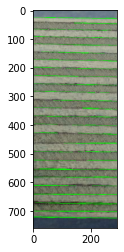

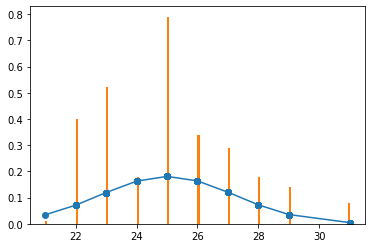

In [13]:
cv2.imwrite('linedetector.jpg',img)
plt.imshow(img)
cv2.imwrite('new_lienes.jpg',new_lienes)
new_lienesbw=cv2.imread('new_lienes.jpg',0)

new_lienesbwblur=cv2.blur(new_lienesbw, (7, 7))
cv2.imwrite('new_lienesblur.jpg',new_lienesbwblur)
lines = cv2.HoughLinesP(new_lienesbwblur,1,np.pi/180,100,minLineLength,maxLineGap)
for linee in lines:
    for x1, y1, x2, y2 in linee:
        cv2.line(new_lienes, (x1, y1), (x2, y2), (0, 255, 0), 1)
cv2.imwrite('new_lienes_fin.jpg',new_lienes)
round=20
clear_matrix=np.zeros(new_lienesbw.shape)
kernel = np.ones((1,20), np.uint8)  # note this is a horizontal kernel
d_im = cv2.dilate(new_lienesbw, kernel, iterations=1)
clear_matrix = cv2.erode(d_im, kernel, iterations=1)
for i in range(clear_matrix.shape[1]):
    column = new_lienesbw[:, i]
    for ind in range(0,len(column)-round,round):
        if np.sum(column[ind:ind+round])>1:
            column[ind]=1
            column[ind+1:ind+round]=0
    clear_matrix[:,i]=column
clear_matrix=np.where(clear_matrix>1, 1, clear_matrix)
veheer_count=np.sort(np.sum(clear_matrix,axis=0))-1
# print(clear_matrix)
# print(veheer_count.shape)
counts, bins = np.histogram(veheer_count,bins=150)
# print(veheer_count)
fit = stats.norm.pdf(veheer_count, np.mean(veheer_count), np.std(veheer_count))
plt.figure()
plt.plot(veheer_count,fit,'-o')
plt.hist(bins[:-1], bins, weights=counts/100)
ans=np.ceil(veheer_count[np.argmax(fit)])
# print(np.ceil(veheer_count[np.argmax(fit)]))
(h, w) = clear_matrix.shape
center = (int(w / 2), int(h / 2))
font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = center
fontScale              = 1
fontColor              = (255,255,255)
lineType               = 2
clear_matrix=clear_matrix*255
cv2.putText(clear_matrix,str(ans),bottomLeftCornerOfText,
    font,
    fontScale,
    fontColor,
    lineType)
# cv2.imshow('clear_matrix.jpg',clear_matrix)

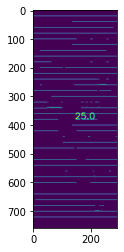

In [14]:
cv2.imwrite('clear_matrix.jpg',clear_matrix)
plt.imshow(clear_matrix)

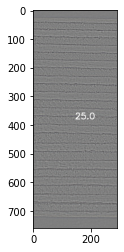

In [15]:
cv2.putText(filtered,str(ans),bottomLeftCornerOfText,
    font,
    fontScale,
    fontColor,
    lineType)
plt.imshow(filtered)


In [16]:
from veneer import Veneer


In [17]:
veneer=Veneer('pic/1.png')

TypeError: object of type 'NoneType' has no len()

In [ ]:
bw=veneer.filt_img()
plt.imshow(bw,cmap='Greys')

In [ ]:
lineimg,lines=veneer.edge_detector(bw)
plt.imshow(lineimg,cmap='Greys')

In [ ]:
ans,img,fe,fig=veneer.count_veneer(lines)
plt.imshow(img)
fig.show()

In [ ]:
veneer=Veneer('pic/2.png')

In [ ]:
bw=veneer.filt_img()
plt.imshow(bw,cmap='Greys')

In [ ]:
lineimg,lines=veneer.edge_detector(bw,minLineLength=10,maxLineGap=5)
plt.imshow(lineimg,cmap='Greys')

In [ ]:
ans,img,fe,fig=veneer.count_veneer(lines)
plt.imshow(img)
fig.show()
print(ans)

In [ ]:
veneer=Veneer('pic/3.jpg')

In [ ]:
bw=veneer.filt_img()
plt.imshow(bw,cmap='Greys')

In [ ]:
lineimg,lines=veneer.edge_detector(bw,minLineLength=100,maxLineGap=20)
plt.imshow(lineimg,cmap='Greys')

In [ ]:
ans,img,fe,figg=veneer.count_veneer(lines,minLineLength=100,maxLineGap=20)
plt.imshow(img)

print(ans)